<a href="https://colab.research.google.com/github/sajjkavinda/cervical-spine-fracture-detection/blob/enhanced/cervical_spine_fracture_detection_enhanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip uninstall -y gdcm python-gdcm pydicom pylibjpeg pylibjpeg-libjpeg pylibjpeg-openjpeg --quiet
!pip install pydicom pylibjpeg pylibjpeg-libjpeg pylibjpeg-openjpeg --quiet
!pip install opencv-python matplotlib tqdm --quiet
!pip install pandas scikit-learn matplotlib tqdm --quiet
!pip install torch torchvision torchaudio --quiet

In [6]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [7]:
!unzip -q "/content/drive/MyDrive/Dataset-RSNA/rsna_subset.zip" -d "/content/rsna_subset" && echo "Unzip completed successfully!"

Unzip completed successfully!


In [8]:
import os
import random
import pydicom
import cv2
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torchvision.models import resnet18, ResNet18_Weights
import torch.optim as optim

In [10]:
import os
import cv2
import pydicom
from tqdm import tqdm

# Paths
DICOM_ROOT = "/content/rsna_subset_images"
IMAGE_ROOT = "/content/rsna_png_images"
os.makedirs(IMAGE_ROOT, exist_ok=True)

# Convert DICOM to PNG
for study_uid in tqdm(os.listdir(DICOM_ROOT)):
    study_path = os.path.join(DICOM_ROOT, study_uid)
    if not os.path.isdir(study_path):
        continue
    png_folder = os.path.join(IMAGE_ROOT, study_uid)
    os.makedirs(png_folder, exist_ok=True)

    dicom_files = [f for f in os.listdir(study_path) if f.lower().endswith(".dcm")]
    if not dicom_files:
        os.rmdir(png_folder)
        continue

    # Take up to 3 middle slices
    dicom_files = sorted(dicom_files)
    mid = len(dicom_files) // 2
    start = max(0, mid-1)
    selected = dicom_files[start:start+3]

    for f in selected:
        dicom_path = os.path.join(study_path, f)
        png_path = os.path.join(png_folder, f.replace(".dcm",".png"))
        try:
            dcm = pydicom.dcmread(dicom_path)
            img = dcm.pixel_array
            img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
            cv2.imwrite(png_path, img)
        except Exception as e:
            print(f"Failed {dicom_path}: {e}")

print("All DICOMs converted. Only folders with PNGs remain.")

# Verify dataset
studies_with_images = [d for d in os.listdir(IMAGE_ROOT) if os.path.isdir(os.path.join(IMAGE_ROOT, d)) and len(os.listdir(os.path.join(IMAGE_ROOT, d)))>0]
print("Studies with images:", len(studies_with_images))


100%|██████████| 800/800 [00:43<00:00, 18.29it/s]

All DICOMs converted. Only folders with PNGs remain.
Studies with images: 800


Train studies: 576 Val studies: 144 Test studies: 80
Samples -> Train: 1728 Val: 432 Test: 240

==== Training simple_cnn ====


  0%|          | 0/108 [00:00<?, ?it/s]

simple_cnn Epoch 1/6 - train_acc:0.530, val_acc:0.546, val_auc:0.539


  0%|          | 0/108 [00:00<?, ?it/s]

simple_cnn Epoch 2/6 - train_acc:0.559, val_acc:0.523, val_auc:0.525


  0%|          | 0/108 [00:00<?, ?it/s]

simple_cnn Epoch 3/6 - train_acc:0.582, val_acc:0.537, val_auc:0.532


  0%|          | 0/108 [00:00<?, ?it/s]

simple_cnn Epoch 4/6 - train_acc:0.598, val_acc:0.560, val_auc:0.544


  0%|          | 0/108 [00:00<?, ?it/s]

simple_cnn Epoch 5/6 - train_acc:0.621, val_acc:0.502, val_auc:0.539


  0%|          | 0/108 [00:00<?, ?it/s]

simple_cnn Epoch 6/6 - train_acc:0.629, val_acc:0.477, val_auc:0.530

==== Training resnet18 ====


  0%|          | 0/108 [00:00<?, ?it/s]

resnet18 Epoch 1/6 - train_acc:0.652, val_acc:0.537, val_auc:0.542


  0%|          | 0/108 [00:00<?, ?it/s]

resnet18 Epoch 2/6 - train_acc:0.818, val_acc:0.479, val_auc:0.519


  0%|          | 0/108 [00:00<?, ?it/s]

resnet18 Epoch 3/6 - train_acc:0.878, val_acc:0.567, val_auc:0.550


  0%|          | 0/108 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cce2199f740>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cce2199f740>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

resnet18 Epoch 4/6 - train_acc:0.914, val_acc:0.479, val_auc:0.565


  0%|          | 0/108 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cce2199f740>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7cce2199f740>
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
        self._shutdown_workers()
self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers

    if w.is_alive():  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers

      if w.is_alive():
          ^ ^ ^^^^^^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7cce2199f740>^
^Traceback (most recent call last):
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/

resnet18 Epoch 5/6 - train_acc:0.939, val_acc:0.560, val_auc:0.566


  0%|          | 0/108 [00:00<?, ?it/s]

resnet18 Epoch 6/6 - train_acc:0.947, val_acc:0.500, val_auc:0.530


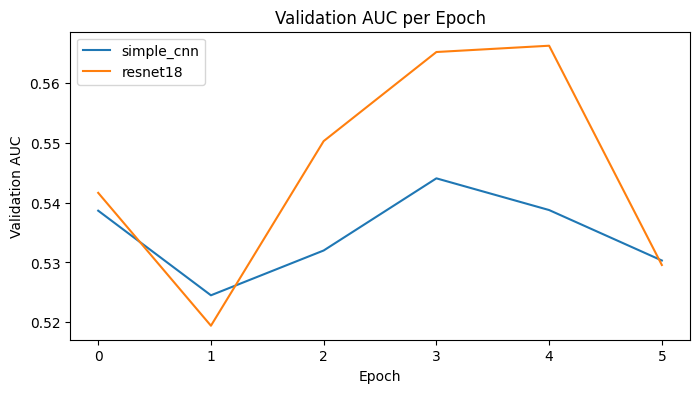

        model    acc   prec    rec     f1   auc
0  simple_cnn  0.477  0.497  0.404  0.446  0.53
1    resnet18  0.500  0.529  0.369  0.435  0.53


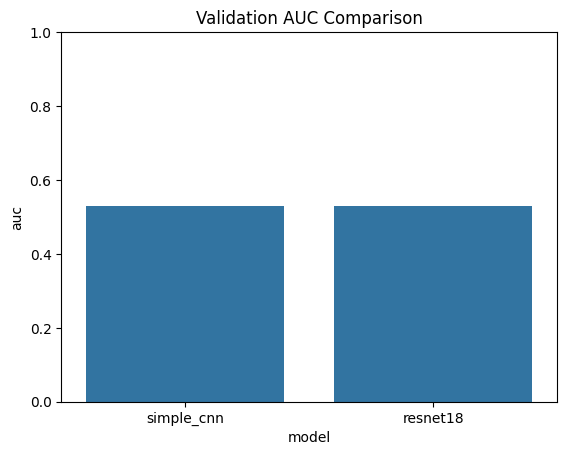


Evaluating simple_cnn on Test Set...

Evaluating resnet18 on Test Set...

Test Set Performance:
        model    acc   prec    rec     f1    auc
0  simple_cnn  0.542  0.583  0.444  0.505  0.636
1    resnet18  0.525  0.583  0.333  0.424  0.600


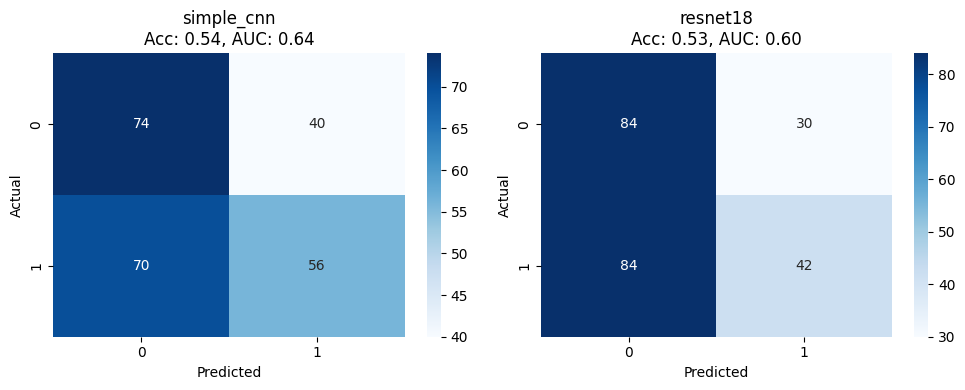

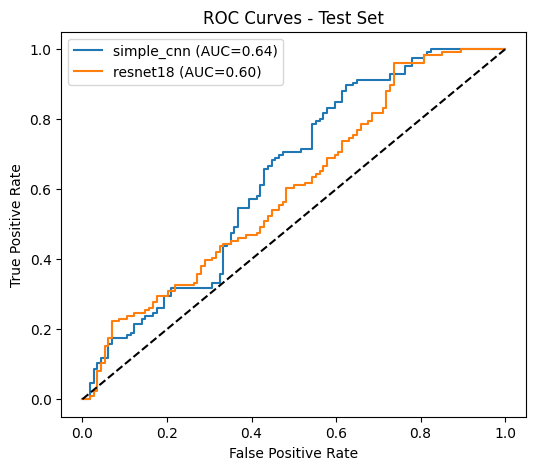

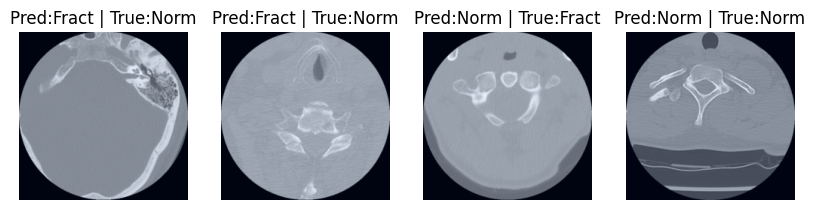

Saved best model to /content/simple_cnn_best.pth


In [12]:
# Imports
import os, random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models import (resnet18, ResNet18_Weights)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

# Paths & config
CSV_DIR = "/content/subset_csv"
IMAGE_ROOT = "/content/rsna_png_images"

BATCH_SIZE = 16
NUM_EPOCHS = 6
LR = 1e-4
NUM_WORKERS = 2
RANDOM_SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Load CSVs
train_df = pd.read_csv(os.path.join(CSV_DIR,"train.csv"))
val_df   = pd.read_csv(os.path.join(CSV_DIR,"val.csv"))
test_df  = pd.read_csv(os.path.join(CSV_DIR,"test.csv"))

print("Train studies:", len(train_df), "Val studies:", len(val_df), "Test studies:", len(test_df))

# Dataset
class RSNADataset(Dataset):
    def __init__(self, df, image_root, transform=None, max_slices_per_study=None):
        self.items = []
        self.transform = transform
        for _, row in df.iterrows():
            uid = row["StudyInstanceUID"]
            label = int(row["patient_overall"])
            study_dir = os.path.join(image_root, uid)
            if not os.path.isdir(study_dir):
                continue
            files = sorted([f for f in os.listdir(study_dir) if f.lower().endswith(('.png'))])
            if len(files) == 0:
                continue
            # Pick slices
            if max_slices_per_study:
                mid = len(files)//2
                half = max_slices_per_study//2
                start = max(0, mid-half)
                chosen = files[start:start+max_slices_per_study]
            else:
                chosen = files
            for f in chosen:
                self.items.append((os.path.join(study_dir,f), label))
        random.shuffle(self.items)
    def __len__(self):
        return len(self.items)
    def __getitem__(self, idx):
        path,label = self.items[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label,dtype=torch.long)

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(8),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
eval_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

MAX_SLICES_PER_STUDY = 3

train_ds = RSNADataset(train_df, IMAGE_ROOT, transform=train_transform, max_slices_per_study=MAX_SLICES_PER_STUDY)
val_ds   = RSNADataset(val_df, IMAGE_ROOT, transform=eval_transform, max_slices_per_study=MAX_SLICES_PER_STUDY)
test_ds  = RSNADataset(test_df, IMAGE_ROOT, transform=eval_transform, max_slices_per_study=MAX_SLICES_PER_STUDY)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print("Samples -> Train:", len(train_ds), "Val:", len(val_ds), "Test:", len(test_ds))

# Models

# Simple CNN
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*14*14, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Build model
def build_model(name):
    if name=="resnet18":
        m = resnet18(weights=ResNet18_Weights.DEFAULT)
        m.fc = nn.Linear(m.fc.in_features,2)
    elif name=="simple_cnn":
        m = SimpleCNN(num_classes=2)
    else:
        raise ValueError(name)
    return m

# Class weights
def compute_class_weights(df_list):
    all_labels = []
    for df in df_list:
        all_labels.extend(df["patient_overall"].astype(int).tolist())
    vals, counts = np.unique(all_labels, return_counts=True)
    total = sum(counts)
    weights = {k: total/(len(vals)*v) for k,v in zip(vals,counts)}
    return torch.tensor([weights.get(0,1.0), weights.get(1,1.0)], dtype=torch.float).to(DEVICE)

# Train one model
def train_one_model(model_name):
    model = build_model(model_name).to(DEVICE)
    class_weights = compute_class_weights([train_df])
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=LR)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)
    history = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[], "val_auc":[]}
    best_auc = 0.0
    best_wts = None
    for epoch in range(NUM_EPOCHS):
        model.train()
        preds_all, labels_all = [], []
        running_loss = 0
        for imgs, labels in tqdm(train_loader, leave=False):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()*imgs.size(0)
            preds_all.extend(torch.argmax(outputs,1).cpu().numpy().tolist())
            labels_all.extend(labels.cpu().numpy().tolist())
        train_loss = running_loss/len(train_loader.dataset)
        train_acc = accuracy_score(labels_all, preds_all)

        # Validation
        model.eval()
        val_preds,val_labels,val_probs=[],[],[]
        val_loss=0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()*imgs.size(0)
                val_probs.extend(torch.softmax(outputs,1)[:,1].cpu().numpy())
                val_preds.extend(torch.argmax(outputs,1).cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        val_loss /= len(val_loader.dataset)
        val_acc = accuracy_score(val_labels, val_preds)
        val_auc = roc_auc_score(val_labels,val_probs) if len(np.unique(val_labels))>1 else 0
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["val_auc"].append(val_auc)
        scheduler.step(val_auc)
        if val_auc>best_auc:
            best_auc=val_auc
            best_wts={k:v.cpu() for k,v in model.state_dict().items()}
        print(f"{model_name} Epoch {epoch+1}/{NUM_EPOCHS} - train_acc:{train_acc:.3f}, val_acc:{val_acc:.3f}, val_auc:{val_auc:.3f}")
    if best_wts:
        model.load_state_dict(best_wts)
    return model, history

# Evaluate model
def evaluate_model(model, loader):
    model.eval()
    preds, probs, labels = [], [], []
    with torch.no_grad():
        for imgs, labs in loader:
            imgs = imgs.to(DEVICE)
            out = model(imgs)
            probs.extend(torch.softmax(out,1)[:,1].cpu().numpy())
            preds.extend(torch.argmax(out,1).cpu().numpy())
            labels.extend(labs.numpy())
    acc = accuracy_score(labels,preds)
    prec = precision_score(labels,preds, zero_division=0)
    rec = recall_score(labels,preds, zero_division=0)
    f1 = f1_score(labels,preds, zero_division=0)
    auc = roc_auc_score(labels,probs) if len(np.unique(labels))>1 else 0
    cm = confusion_matrix(labels,preds)
    fpr,tpr,_ = roc_curve(labels,probs) if len(np.unique(labels))>1 else (None,None,None)
    return {"acc":acc,"prec":prec,"rec":rec,"f1":f1,"auc":auc,"cm":cm,"fpr":fpr,"tpr":tpr}

# Train and Evaluate Two Models
model_names = ["simple_cnn", "resnet18"]
trained_models = {}
histories = {}
eval_results = {}

for name in model_names:
    print(f"\n==== Training {name} ====")
    m, h = train_one_model(name)
    trained_models[name] = m
    histories[name] = h
    eval_results[name] = evaluate_model(m, val_loader)

# Validation AUC plot
plt.figure(figsize=(8,4))
for name,h in histories.items():
    plt.plot(h["val_auc"], label=name)
plt.xlabel("Epoch")
plt.ylabel("Validation AUC")
plt.title("Validation AUC per Epoch")
plt.legend()
plt.show()

# Validation metrics comparison
rows = []
for name,res in eval_results.items():
    rows.append({
        "model": name,
        "acc": res["acc"],
        "prec": res["prec"],
        "rec": res["rec"],
        "f1": res["f1"],
        "auc": res["auc"]
    })
res_df = pd.DataFrame(rows).sort_values("auc", ascending=False)
print(res_df.round(3))
sns.barplot(x="model", y="auc", data=res_df)
plt.title("Validation AUC Comparison")
plt.ylim(0,1)
plt.show()

# Test set evaluation
test_eval_all = {}
for name, model in trained_models.items():
    print(f"\nEvaluating {name} on Test Set...")
    test_eval_all[name] = evaluate_model(model, test_loader)

# Test metrics comparison
rows = []
for name,res in test_eval_all.items():
    rows.append({
        "model": name,
        "acc": res["acc"],
        "prec": res["prec"],
        "rec": res["rec"],
        "f1": res["f1"],
        "auc": res["auc"]
    })
test_df = pd.DataFrame(rows).sort_values("auc", ascending=False)
print("\nTest Set Performance:")
print(test_df.round(3))

# Confusion matrices
fig, axes = plt.subplots(1,len(test_eval_all), figsize=(5*len(test_eval_all),4))
for i,(model_name,res) in enumerate(test_eval_all.items()):
    ax = axes[i] if len(test_eval_all)>1 else axes
    sns.heatmap(res["cm"], annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(f"{model_name}\nAcc: {res['acc']:.2f}, AUC: {res['auc']:.2f}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC curves
plt.figure(figsize=(6,5))
for name,res in test_eval_all.items():
    if res.get("fpr") is not None and res.get("tpr") is not None:
        plt.plot(res["fpr"], res["tpr"], label=f"{name} (AUC={res['auc']:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curves - Test Set")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Sample predictions from the best model
best_model_name = test_df.iloc[0]["model"]
best_model = trained_models[best_model_name]

def show_samples(model, dataset, n_pos=2, n_neg=2):
    model.eval()
    pos_shown, neg_shown = 0,0
    fig = plt.figure(figsize=(10,5))
    for i in range(len(dataset)):
        img,label = dataset[i]
        with torch.no_grad():
            out = model(img.unsqueeze(0).to(DEVICE))
            pred = torch.argmax(out,1).item()
        if pred==1 and pos_shown<n_pos:
            ax = fig.add_subplot(1,n_pos+n_neg,pos_shown+1)
            img_np = img.permute(1,2,0).cpu().numpy()
            img_np = (img_np-img_np.min())/(img_np.max()-img_np.min()+1e-8)
            ax.imshow(img_np)
            ax.set_title(f"Pred:Fract | True:{'Fract' if label==1 else 'Norm'}")
            ax.axis("off")
            pos_shown+=1
        if pred==0 and neg_shown<n_neg:
            ax = fig.add_subplot(1,n_pos+n_neg,n_pos+neg_shown+1)
            img_np = img.permute(1,2,0).cpu().numpy()
            img_np = (img_np-img_np.min())/(img_np.max()-img_np.min()+1e-8)
            ax.imshow(img_np)
            ax.set_title(f"Pred:Norm | True:{'Fract' if label==1 else 'Norm'}")
            ax.axis("off")
            neg_shown+=1
        if pos_shown>=n_pos and neg_shown>=n_neg:
            break
    plt.show()

show_samples(best_model, test_ds)
